# 내가 관심있는 작가의 구독자들이 좋아하는 작가 추천

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import requests
import json
from bs4 import BeautifulSoup
%matplotlib inline

In [2]:
## road pickle data
import pickle
pkl_file = open('/Users/goodvc/Data/fc-recsys-school/ch1/resource/brunch_sns.pkl', 'rb')
ds_dict = pickle.load(pkl_file)
pkl_file.close() 

In [5]:
ds_dict.keys()

[u'goodvc78', u'leaven', u'suyoung', u'lifidea']

In [9]:
## 관심 작가 정보 크롤링 하기 
## extract Brunch Writer Info : uid, name, text-count, megazine-count, follower-count, following-count:
def extractWriterInfo(uid):
    try:
        response = requests.get("http://brunch.co.kr/@{uid}".format(uid=uid) )
    except Exception:
        []
        
    data = response.content.decode('utf-8')
    soup = BeautifulSoup(data, 'html.parser')
    
    ## name 
    names = soup.find_all("strong", class_="profileUserName")
    name = uid if len(names)<1 else names[0].getText()
    
    classes = soup.find_all("span", class_="num_count")
    reserved = [uid, name]
    for c in classes:
        reserved.append(int(c.getText().replace(',','')))
    return reserved

#print extractWriterInfo('goodvc78')

In [10]:
def toDataframe(src) :
    data = []
    for n, f in src.items():
        for nn in f['following']:
            data.append([n,'following',nn])
    df = pd.DataFrame(data, columns=['uid','dir','target'])
    return df[~df.target.isin(['brunch'])]

In [11]:
df = toDataframe(ds_dict['goodvc78'])
df = df[~df.target.isin(['goodvc78','brunch'])]

### 상위 브런치 작가

In [12]:
## 상위 50 작가 선정 
topn=50
top_writer = df[df.dir=='following'].groupby('target').count().sort('uid', ascending=False)[:topn][['dir']]

top_writer = top_writer.reset_index()
top_writer.columns = ['uid','교차 구독자수']

## 상위 작가의 bruch 정보 가져오기 ( 크롤링 ) 
top_writer_info = []
for uid in top_writer.uid:
    top_writer_info.append(extractWriterInfo(uid))
top_writer_info = pd.DataFrame(top_writer_info, columns=['uid','작가명','글 수', '매거진수', '비교작가 구독자수', '관심작가수' ])

In [13]:
top_writer_info.head()

,uid,작가명,글 수,매거진수,비교작가 구독자수,관심작가수
0,lifidea,Jin Young Kim,11,1,805,195
1,brunchflgu,조우성 변호사,675,10,5268,35
2,insuk,조인석 chris,10,1,944,29
3,jimmyrim,임지훈 Jimmy Rim,6,0,2476,0
4,yoojs8512,유재석,46,1,1470,24


In [14]:
## 데이터 머지 
top_writer = pd.merge(top_writer, top_writer_info, on=['uid'])

In [18]:
top_writer.head()

,uid,교차 구독자수,작가명,글 수,매거진수,비교작가 구독자수,관심작가수,관심작가 구독자수
0,lifidea,42,Jin Young Kim,11,1,805,195,132
1,brunchflgu,33,조우성 변호사,675,10,5268,35,132
2,insuk,30,조인석 chris,10,1,944,29,132
3,jimmyrim,30,임지훈 Jimmy Rim,6,0,2476,0,132
4,yoojs8512,29,유재석,46,1,1470,24,132


In [16]:
top_writer['관심작가 구독자수'] = len(ds_dict['goodvc78'].keys())

In [17]:
top_writer.head()

,uid,교차 구독자수,작가명,글 수,매거진수,비교작가 구독자수,관심작가수,관심작가 구독자수
0,lifidea,42,Jin Young Kim,11,1,805,195,132
1,brunchflgu,33,조우성 변호사,675,10,5268,35,132
2,insuk,30,조인석 chris,10,1,944,29,132
3,jimmyrim,30,임지훈 Jimmy Rim,6,0,2476,0,132
4,yoojs8512,29,유재석,46,1,1470,24,132


In [22]:
## 전체 구독수대비 나의 구독자수 비율
top_writer['교차 구독자수 비율'] = top_writer['교차 구독자수'] \
    / (top_writer['비교작가 구독자수'] + top_writer['관심작가 구독자수'] - top_writer['교차 구독자수']  )

top_writer['교차 구독자수 비율'] = top_writer['교차 구독자수 비율'].apply(lambda x: round(x,3))

In [23]:
top_writer.head()

,uid,교차 구독자수,작가명,글 수,매거진수,비교작가 구독자수,관심작가수,관심작가 구독자수,교차 구독자수 비율
0,lifidea,42,Jin Young Kim,11,1,805,195,132,0.047
1,brunchflgu,33,조우성 변호사,675,10,5268,35,132,0.006
2,insuk,30,조인석 chris,10,1,944,29,132,0.029
3,jimmyrim,30,임지훈 Jimmy Rim,6,0,2476,0,132,0.012
4,yoojs8512,29,유재석,46,1,1470,24,132,0.018


In [24]:
def rankBy( ds, colname, topn=10 ):
    ranked = ds.sort(colname, ascending=False)[['uid','작가명','관심작가 구독자수', '교차 구독자수','비교작가 구독자수', '교차 구독자수 비율']][:topn]
    for (name,row) in ranked.iterrows():
        print ("https://brunch.co.kr/@{name}".format(name=row['uid'], value=row['작가명']))
    return ranked
#rankBy( top_writer, '나의 구독자수')

In [25]:
rankBy( top_writer, '교차 구독자수')

https://brunch.co.kr/@lifidea
https://brunch.co.kr/@brunchflgu
https://brunch.co.kr/@insuk
https://brunch.co.kr/@jimmyrim
https://brunch.co.kr/@yoojs8512
https://brunch.co.kr/@suyoung
https://brunch.co.kr/@suhanjang
https://brunch.co.kr/@pelexus
https://brunch.co.kr/@wjchee
https://brunch.co.kr/@mobiinside


,uid,작가명,관심작가 구독자수,교차 구독자수,비교작가 구독자수,교차 구독자수 비율
0,lifidea,Jin Young Kim,132,42,805,0.047
1,brunchflgu,조우성 변호사,132,33,5268,0.006
2,insuk,조인석 chris,132,30,944,0.029
3,jimmyrim,임지훈 Jimmy Rim,132,30,2476,0.012
4,yoojs8512,유재석,132,29,1470,0.018
5,suyoung,강수영,132,26,1270,0.019
6,suhanjang,티거 Jang,132,23,5118,0.004
7,pelexus,최윤섭,132,21,824,0.022
8,wjchee,지원준,132,20,477,0.034
9,mobiinside,Mobiinside,132,19,846,0.020


In [26]:
rankBy( top_writer, '비교작가 구독자수')

https://brunch.co.kr/@brunchflgu
https://brunch.co.kr/@suhanjang
https://brunch.co.kr/@rothem
https://brunch.co.kr/@haneulalice
https://brunch.co.kr/@jimmyrim
https://brunch.co.kr/@2kija
https://brunch.co.kr/@sooscape
https://brunch.co.kr/@yoonash
https://brunch.co.kr/@yoojs8512
https://brunch.co.kr/@sshong


,uid,작가명,관심작가 구독자수,교차 구독자수,비교작가 구독자수,교차 구독자수 비율
1,brunchflgu,조우성 변호사,132,33,5268,0.006
6,suhanjang,티거 Jang,132,23,5118,0.004
31,rothem,Rothem,132,12,2697,0.004
10,haneulalice,Alice in wonderland,132,19,2580,0.007
3,jimmyrim,임지훈 Jimmy Rim,132,30,2476,0.012
41,2kija,이기주작가,132,11,2272,0.005
11,sooscape,흔디,132,19,1765,0.010
12,yoonash,yoonash,132,18,1482,0.011
4,yoojs8512,유재석,132,29,1470,0.018
34,sshong,홍순성,132,12,1398,0.008


In [27]:
rankBy( top_writer, '교차 구독자수 비율')

https://brunch.co.kr/@cojette
https://brunch.co.kr/@aidenswmo
https://brunch.co.kr/@lifidea
https://brunch.co.kr/@cloud09
https://brunch.co.kr/@manya
https://brunch.co.kr/@yper
https://brunch.co.kr/@genie7pe
https://brunch.co.kr/@wjchee
https://brunch.co.kr/@alden
https://brunch.co.kr/@jaeseungmun


,uid,작가명,관심작가 구독자수,교차 구독자수,비교작가 구독자수,교차 구독자수 비율
16,cojette,cojette,132,16,101,0.074
36,aidenswmo,모상우,132,12,69,0.063
0,lifidea,Jin Young Kim,132,42,805,0.047
35,cloud09,강한별,132,12,173,0.041
14,manya,마냐,132,18,341,0.040
19,yper,문현구 YPER 대표,132,15,313,0.035
40,genie7pe,Chulhyun Cho,132,11,199,0.034
8,wjchee,지원준,132,20,477,0.034
29,alden,강진우,132,12,237,0.034
39,jaeseungmun,Jaeseung Mun,132,11,215,0.033


---



# 브런치 작가 Clustering


In [28]:
from scipy.spatial import distance 
from scipy import stats
import seaborn as sns
import scipy

def cos_cdist(matrix, vector, dist):
    """
    Compute the cosine distances between each row of matrix and vector.
    """
    v = vector.reshape(1, -1)
    return scipy.spatial.distance.cdist(matrix, v, 'cosine').reshape(-1)

def matrix_similarity( matrix_ds, dist='jaccard'):
    
    sim_mat = []
    name = []
    for idx, row in matrix_ds.iterrows():
        name.append(idx)
        sim_mat.append(cos_cdist( matrix_ds, row, dist ).tolist())
    ds = 1-pd.DataFrame(sim_mat, columns=name, index=name)
    return ds

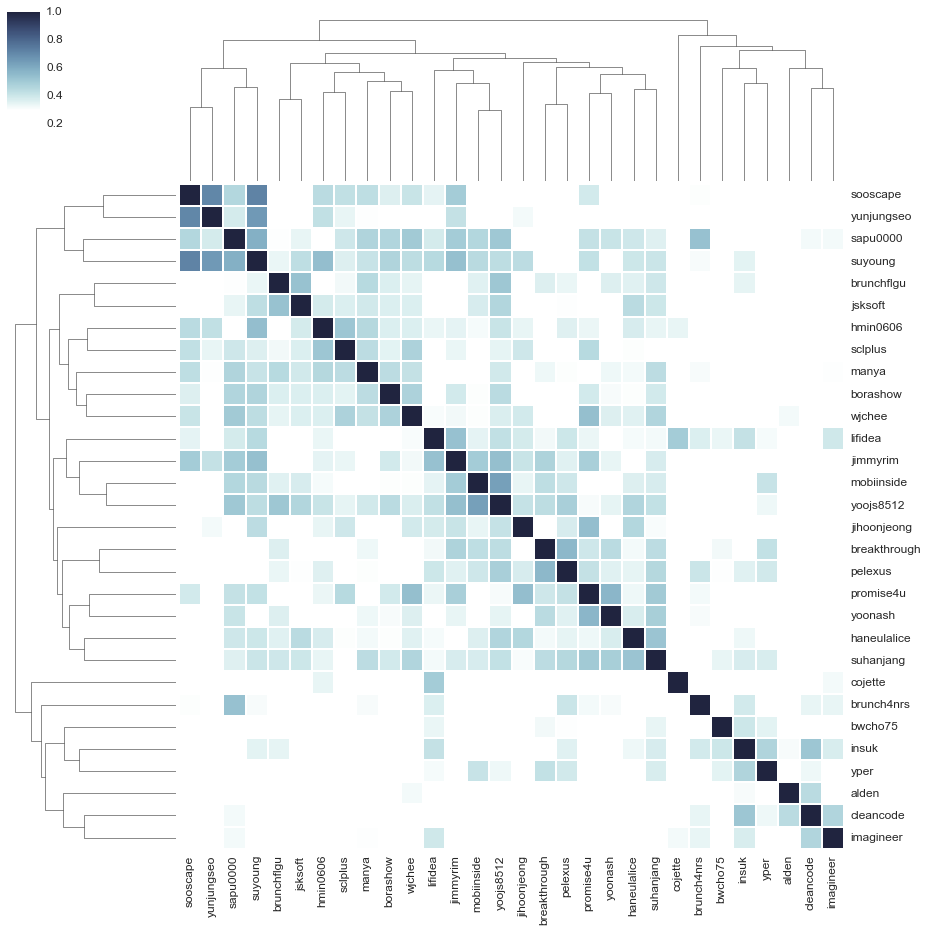

In [29]:
## data 만들기
tmp_ds = df[df.target.isin(top_writer[:30].uid)]
writer_ds = pd.pivot_table( tmp_ds, index='target', columns='uid', values='dir', aggfunc=len, fill_value=0)
ds = matrix_similarity( writer_ds )

## 테마 셋팅
sns.set(style="whitegrid", palette="pastel", color_codes=True,font_scale=1.2)
cmap = sns.cubehelix_palette(as_cmap=True, rot=-.2, light=1.3)

## clustering & visualization
cm = sns.clustermap(ds, cmap=cmap, linewidths=.5)

## figure size 
cm.fig.set_figwidth(15)
cm.fig.set_figheight(15)

In [30]:
for idx,row in top_writer[:30].sort('uid').iterrows():
    print( u"https://brunch.co.kr/@{uid} {name}".format(uid=row.uid, name=row['작가명']))

https://brunch.co.kr/@alden 강진우
https://brunch.co.kr/@borashow 보라쇼
https://brunch.co.kr/@breakthrough 한국현
https://brunch.co.kr/@brunch4nrs 윤청하
https://brunch.co.kr/@brunchflgu 조우성 변호사
https://brunch.co.kr/@bwcho75 조대협
https://brunch.co.kr/@cleancode 백명석
https://brunch.co.kr/@cojette cojette
https://brunch.co.kr/@haneulalice Alice in wonderland
https://brunch.co.kr/@hmin0606 신유민
https://brunch.co.kr/@imagineer 더할 나위 없이
https://brunch.co.kr/@insuk 조인석 chris
https://brunch.co.kr/@jihoonjeong 정지훈
https://brunch.co.kr/@jimmyrim 임지훈 Jimmy Rim
https://brunch.co.kr/@jsksoft 상상
https://brunch.co.kr/@lifidea Jin Young Kim
https://brunch.co.kr/@manya 마냐
https://brunch.co.kr/@mobiinside Mobiinside
https://brunch.co.kr/@pelexus 최윤섭
https://brunch.co.kr/@promise4u 양준철
https://brunch.co.kr/@sapu0000 송준협
https://brunch.co.kr/@sclplus 엄지용
https://brunch.co.kr/@sooscape 흔디
https://brunch.co.kr/@suhanjang 티거 Jang
https://brunch.co.kr/@suyoung 강수영
https://brunch.co.kr/@wjchee 지원준
https://brunch.co.kr/@yoo

### 클러스터 1번
UX, 디자인 관련 글이 주를 이루는 UX,디자인,기획을 업으로 하시는 작가분
* https://brunch.co.kr/@yunjungseo Yunjung Seo
* https://brunch.co.kr/@hmin0606 신유민 
* https://brunch.co.kr/@suyoung 강수영
* https://brunch.co.kr/@meanimize Meanimize
* https://brunch.co.kr/@sooscape 흔디
* https://brunch.co.kr/@sapu0000 송준협
---
### 클러스터 2번
개발자 문화에 관련된 글이 주를 이루는 개발을 업으로하시는 작가분(대체적으로 글수가 10개 이하로 적음)
* https://brunch.co.kr/@brunch4nrs 윤청하
* https://brunch.co.kr/@brunchlftm sbroh
* https://brunch.co.kr/@insuk 조인석 chris
* https://brunch.co.kr/@pelexus 최윤섭
---
### 클러스터 3번
스타트업 문화, 회사의 생활, 직무, 업무 멘토링 등과 관련된 글이 많은 작가분들임
* https://brunch.co.kr/@promise4u 양준철
* https://brunch.co.kr/@yoonash yoonash
* https://brunch.co.kr/@aboutheman 퀘벤하운
* https://brunch.co.kr/@aboutheman 퀘벤하운
* https://brunch.co.kr/@jihoonjeong 정지훈
* https://brunch.co.kr/@haneulalice Alice in wonderland
* https://brunch.co.kr/@suhanjang 티거 Jang
---
### 클러스터 4번
IT 트랜드, 컬럼, 사회 현상에 대한 내용을 담은 작가분들임
* https://brunch.co.kr/@sclplus 엄지용
* https://brunch.co.kr/@wjchee 지원준
* https://brunch.co.kr/@jsksoft 상상
* https://brunch.co.kr/@borashow 보라쇼
* https://brunch.co.kr/@manya 마냐
---
### 클러스터 5번
4번 클러스터와 유사하게 IT/모바일 트렌드, 데이터과학 등 저널의 성향이 있는 작가분들임
* https://brunch.co.kr/@genie7pe Chulhyun Cho
* https://brunch.co.kr/@jaeseungmun Jaeseung Mun
* https://brunch.co.kr/@sapu0000 송준협
* https://brunch.co.kr/@jimmyrim 임지훈 Jimmy Rim
* https://brunch.co.kr/@mobiinside Mobiinside
* https://brunch.co.kr/@yoojs8512 유재석
* https://brunch.co.kr/@lifidea Jin Young Kim


--- 
# 다양한 작가들과 함께분석 

### 작가를 벡터 공간에 임베딩하기 

In [31]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import rcParams
from datetime import datetime
import gensim, logging
import random
%matplotlib inline  

rcParams['font.family'] = 'AppleGothic'
rcParams.update({'font.size': 14})

In [32]:
## road pickle data

pkl_file = open('/Users/goodvc/Data/fc-recsys-school/ch1/resource/brunch_sns.pkl', 'rb')
writers_dict = pickle.load(pkl_file)
pkl_file.close() 

In [33]:
for id in writers_dict.keys():
    print("https://brunch.co.kr/@{0}".format(id))

https://brunch.co.kr/@goodvc78
https://brunch.co.kr/@leaven
https://brunch.co.kr/@suyoung
https://brunch.co.kr/@lifidea


In [34]:
# word2vec으로 학습할 corpus 만들기 
corpus = []
for owner, folloings in writers_dict.items():
    #if owner != 'goodvc78':
    #    continue
    corpus = corpus + [ f['following']  for n, f in folloings.items() ] 

In [35]:
import gensim, logging
model = gensim.models.Word2Vec(corpus, min_count=10,size=100, window=10)

In [36]:
print (u"작가수 %d" % model.syn0.shape[0])

작가수 1077


In [39]:
for id, sim in model.most_similar(positive=['cojette'],topn=20):
    print( "{1}   https://brunch.co.kr/@{0}".format(id, sim)) 

0.999860703945   https://brunch.co.kr/@youngwungkim
0.999853134155   https://brunch.co.kr/@eunwoopark
0.999845743179   https://brunch.co.kr/@aidenswmo
0.99984139204   https://brunch.co.kr/@koreajb
0.999814510345   https://brunch.co.kr/@pelexus
0.999807476997   https://brunch.co.kr/@yper
0.999806642532   https://brunch.co.kr/@marsnine
0.999803185463   https://brunch.co.kr/@hika
0.999791443348   https://brunch.co.kr/@imagineer
0.999787449837   https://brunch.co.kr/@sophie89
0.999783873558   https://brunch.co.kr/@jmh5531
0.999777674675   https://brunch.co.kr/@jino
0.999777436256   https://brunch.co.kr/@kkonal
0.999770879745   https://brunch.co.kr/@jowlee
0.999764621258   https://brunch.co.kr/@breakthrough
0.999762237072   https://brunch.co.kr/@myte
0.999760687351   https://brunch.co.kr/@pigs
0.999749541283   https://brunch.co.kr/@dsuh
0.999747991562   https://brunch.co.kr/@nanta23
0.999741256237   https://brunch.co.kr/@jsksoft
